# TensorFlow: Optimization & Training (Expert)

https://www.tensorflow.org/  
공식 홈페이지에서 설명하는 Expert 버젼을 배워보자

In [1]:
import tensorflow as tf
from tensorflow.keras import layers

from tensorflow.keras import datasets 

## 학습 과정 돌아보기

![image.png](attachment:image.png)

# Build Model

![image.png](attachment:image.png)

In [2]:
input_shape = (28, 28, 1)
num_classes = 10

In [3]:
inputs = layers.Input(input_shape, dtype=tf.float64)
net = layers.Conv2D(32, (3, 3), padding='SAME')(inputs)
net = layers.Activation('relu')(net)
net = layers.Conv2D(32, (3, 3), padding='SAME')(net)
net = layers.Activation('relu')(net)
net = layers.MaxPooling2D(pool_size=(2, 2))(net)
net = layers.Dropout(0.5)(net)

net = layers.Conv2D(64, (3, 3), padding='SAME')(net)
net = layers.Activation('relu')(net)
net = layers.Conv2D(64, (3, 3), padding='SAME')(net)
net = layers.Activation('relu')(net)
net = layers.MaxPooling2D(pool_size=(2, 2))(net)
net = layers.Dropout(0.5)(net)

net = layers.Flatten()(net)
net = layers.Dense(512)(net)
net = layers.Activation('relu')(net)
net = layers.Dropout(0.5)(net)
net = layers.Dense(num_classes)(net)
net = layers.Activation('softmax')(net)

model = tf.keras.Model(inputs=inputs, outputs=net, name='Basic_CNN')

# Preprocess

텐서플로우 공식홈페이지에서 말한 expert한 방법
- tf.data 사용

In [4]:
mnist = tf.keras.datasets.mnist

# Load Data from MNIST
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Channel 차원 추가
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

# Data Normalization
x_train, x_test = x_train / 255., x_test / 255.

- from_tensor_slices()
- shuffle()
- batch()

In [5]:
import numpy as np
np.min(x_train), np.max(x_train)

(0.0, 1.0)

## tf.data

In [6]:
# train model.fit 하기전 설정
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = train_ds.shuffle(1000) 
train_ds = train_ds.batch(32)

# test model.fit 하기전 설정
# 학습이 아니기 때문에 shuffle 안해도됨
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_ds = test_ds.batch(32)

### Visualize Data

matplotlib 불러와서 데이터 시각화하기

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

train_ds.take()
- 몇개의 스택만큼 가져오는가?

In [12]:
image, label = next(iter(train_ds))

In [15]:
image.shape, label.shape

(TensorShape([32, 28, 28, 1]), TensorShape([32]))

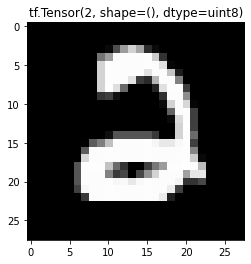

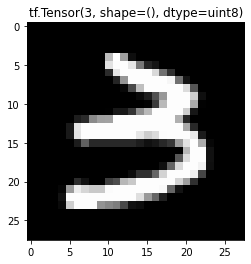

In [21]:
# (32, 28, 28, 1)
# 이미지(x_train)와 레이블(y_train)을 받음
for image, label in train_ds.take(2):
  plt.title(str(label[0])) 
  plt.imshow(image[0, :, :, 0], 'gray')
  plt.show()

# Training (Keras)

Keras로 학습 할 때는 기존과 같지만, train_ds는 generator라서 그대로 넣을 수 있음

In [29]:
#케라스로 학습하는 방법(여기서는 사용하지 x)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
model.fit(train_ds, epochs=10)

Epoch 1/10000
 907/1875 [=============>................] - ETA: 1:07 - loss: 0.1383

KeyboardInterrupt: 

# Optimization  

- Loss Function
- Optimizer

In [24]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

optimizer = tf.keras.optimizers.Adam()

- Loss Function를 담을 곳
- Metrics

In [25]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

# Training  

@tf.function - 기존 session 열었던 것처럼 바로 작동 안 하고, 그래프만 만들고 학습이 시작되면 돌아가도록 함

In [26]:
# train
@tf.function
def train_step(images, labels):
  # 기울기를 얻어 학습을 하게 끔
  with tf.GradientTape() as tape:
    predictions = model(images) # train 모델에다 이미지를 넣어서 예측을 함
    loss = loss_object(labels, predictions) # 레이블과 예측이미지를 계산

  gradients = tape.gradient(loss, model.trainable_variables) # loss을 통해 기울기를 알아냄
  optimizer.apply_gradients(zip(gradients, model.trainable_variables)) # 기울기를 optimizer에 적용

  train_loss(loss)
  train_accuracy(labels, predictions)

In [27]:
# test 
@tf.function
def test_step(images, labels):
    predictions = model(images) # train 모델에다 이미지를 넣어서 예측을 함
    t_loss = loss_object(labels, predictions) # 레이블과 예측이미지를 계산

    test_loss(t_loss) # 확인용
    test_accuracy(labels, predictions)

In [30]:
# 학습하고 테스트하고 반복 
for epoch in range(2):
  for images, labels in train_ds:
    train_step(images, labels) # train_step 함수 작동

  for test_images, test_labels in test_ds:
    test_step(test_images, test_labels) # test_step 함수 작동
  
  template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss : {}, Test Accuracy : {}'

  print(template.format(epoch+1,
                        train_loss.result(),
                        train_accuracy.result()*100,
                        
                        test_loss.result(),
                        test_accuracy.result()*100))

Epoch 1, Loss: 0.06337744742631912, Accuracy: 98.05247497558594, Test Loss : 0.03556415066123009, Test Accuracy : 98.87999725341797


KeyboardInterrupt: 